In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt

from monte_carlo import wolff_algorithm
from xy_model import XYModel2DWolff
from logger import Logger
import pickle

def show_spin(xy_model: XYModel2DWolff):
    x, y = np.meshgrid(np.arange(xy_model.grid_size), np.arange(xy_model.grid_size))
    spin = xy_model.get_spin()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(3, 3)
    ax.quiver(x, y, spin.cos(), spin.sin())
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax

def set_seed(seed):
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

get_M = lambda spin: (spin.cos().sum().square() + spin.sin().sum().square()).sqrt() / spin.size(0) ** 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
set_seed(0)
step_num = 1000
L = 10
Ts = np.linspace(0.1, 2, 100)

loggers = []
for i, T in enumerate(Ts):
    print(f'{i} runs out of {Ts.shape[0]}')
    xy_model = XYModel2DWolff(grid_size=15)
    loggers.append(wolff_algorithm(xy_model, T, int(1e3), flip_all=False))


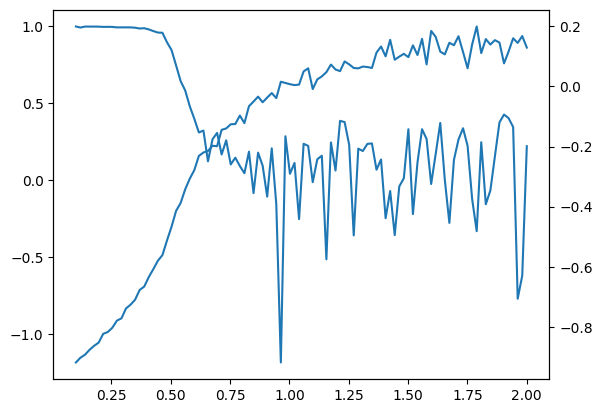

In [27]:


def binning_avg(func):
    idxs = [np.arange(200 - i, 1000 - i, 7) for i in range(100)]
    def wrapper(spins):
        return np.array([func(spins, idx=idxi) for idxi in idxs]).mean()
    return wrapper

@binning_avg
def binder_cumulant(spins, idx):
    spins = spins[idx]
    m = (spins.sin().mean((-1, -2)) ** 2 + spins.cos().mean((-1, -2)) ** 2).sqrt()
    binder = 2 - (m ** 4).mean() / ((m ** 2).mean() ** 2)
    return binder

@binning_avg
def energy(spins, idx):
    spins = spins[idx]
    col = (spins[:, 1:, :] - spins[:, :-1, :]).cos().mean((-1, -2)) / 2
    row = (spins[:, :, 1:] - spins[:, :, :-1]).cos().mean((-1, -2)) / 2
    return -(row + col).mean()

# Ts = np.linspace(0.1, 1, 100)
b = []
e = []

for logger in loggers:
    b.append(binder_cumulant(logger.states[:, 0, ...]))
    e.append(energy(logger.states[:, 0, ...]))

fig, ax = plt.subplots(1, 1)
ax.plot(Ts, b)
ax.twinx().plot(Ts, e)

torch.Size([1000, 3, 15, 15])
